In [1]:
# import pdb
import sys
import common
import argparse
import datasets
import numpy as np
import pandas as pd
import IPython as ip
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import estimators as estimators_lib
import itertools
import tensorflow as tf
import tensorflow_lattice as tfl
#from LatticeCDF import LatticeCDF, execute_query

2023-03-28 22:33:02.081755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)

    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng,
                                                  dataset)
    sel = cal_true_card(
        (cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset):
    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    cols = np.take(table.columns, idxs)

    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    # ops = rng.choice(['<=', '>=', '='], size=num_filters)
    # ops = rng.choice(['<=', '>'], size=num_filters)
    ops = rng.choice(['<='], size=num_filters)

    #     ops_all_eqs = ['='] * num_filters
    #     sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    #     ops = np.where(sensible_to_do_range, ops, ops_all_eqs)

    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals

    # vals = vals[idxs]    ## this is fixed to row
    vals = []              ## this will sample in rows
    for i in range(num_filters):
        s = table.data.iloc[rng.randint(0, table.data.shape[0])]
        vals.append(s.values[idxs][i])

    vals = np.array(vals)

    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])

    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values

In [3]:
def dictionary_column_interval(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        _, col_idxs, _, vals, _ = query
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]  # use [0] to represent empty column interval
        else:
            column_interval[k] = sorted(list(v))
    return column_interval

In [4]:
# 修改区间对 > >= < = 均适用
# 修改 初始interval
# 修改空interval使用【1】
# 修改最小值最大值为：0～min， max～max+max-max_2

In [5]:
def count_column_unique_interval(unique_intervals):
    # count unique query interval in each column
    return [len(v) for v in unique_intervals.values()]

In [6]:
def execute_query(dataNew, query_set):
    diff = []
    for query in query_set:
        sentence = ''
        for i in range(len(query[0])):
            if i != 0:
                sentence += ' and '
            sentence += f'col_{query[1][i]}'
            if query[2][i][0] == '=':
                sentence += '=='
            else:
                sentence += query[2][i][0]
            sentence += f'{query[3][i][0]}'
        sel = dataNew.query(sentence).shape[0] / dataNew.shape[0]
        sel2 = query[4]  # round(query[4] * n_row)
        if sel == 0:
            sel += 1 / dataNew.shape[0]
        if sel2 == 0:
            sel2 += 1 / n_row
        if sel < sel2:
            diff.append(sel2 / sel)
        else:
            diff.append(sel / sel2)
    return diff

In [7]:
def print_error(diff, args):
    print(
    f"\n\n Q-error of Lattice (dataset={args.dataset}, query size={args.query_size}, condition={args.num_conditions}):\n"
)
    print(f"min:    {np.min(diff)}")
    print(f"10:     {np.percentile(diff, 10)}")
    print(f"20:     {np.percentile(diff, 20)}")
    print(f"30:     {np.percentile(diff, 30)}")
    print(f"40:     {np.percentile(diff, 40)}")
    print(f"median: {np.median(diff)}")
    print(f"60:     {np.percentile(diff, 60)}")
    print(f"70:     {np.percentile(diff, 70)}")
    print(f"80:     {np.percentile(diff, 80)}")
    print(f"90:     {np.percentile(diff, 90)}")
    print(f"95:     {np.percentile(diff, 95)}")
    print(f"99:     {np.percentile(diff, 99)}")
    print(f"max:    {np.max(diff)}")
    print(f"mean:   {np.mean(diff)}")

In [8]:
class LatticeCDF:
    def __init__(self,
                 name,
                 n_row,
                 unique_intervals,
                 pwl_keypoints=None,   # also can input table unique values
                 lattice_size=2,
                 l2=1e-2):
        
        self.l2 = l2
        self.name = name
        self.n_row = n_row
        self.dim = len(unique_intervals.keys())
        self.lattice_size = lattice_size
        self.unique_intervals = unique_intervals
        self.pwl_calibration_input_keypoints = unique_intervals if pwl_keypoints is None else pwl_keypoints
        self.sample_feat = None

        self.model_inputs = []
        for i in range(self.dim):
            self.model_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s' % i))
            # self.model_inputs.append(
            #     tf.keras.layers.Input(shape=[1], name='col%s_l' % i))
            # self.model_inputs.append(
            #     tf.keras.layers.Input(shape=[1], name='col%s_u' % i))

        self.calibrators = []
        for i in range(self.dim):
            # self.calibrators.append(
            #     tfl.layers.PWLCalibration(
            #         input_keypoints=np.linspace(
            #             feat_mins[i],
            #             feat_maxs[i],
            #             num=pwl_calibration_num_keypoints),
            #         dtype=tf.float32,
            #         output_min=0.0,
            #         output_max=lattice_size - 1.0,
            #         monotonicity='decreasing',
            #     ))
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(
                        self.pwl_calibration_input_keypoints[i]),
                    # input_keypoints=np.linspace(
                    #     feat_mins[i],
                    #     feat_maxs[i],
                    #     num=pwl_calibration_num_keypoints),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='increasing',
                ))

        self.lattice = tfl.layers.Lattice(
            lattice_sizes=[lattice_size] * self.dim,  # (self.dim * 2),
            interpolation='simplex',    # 可以尝试别的插值类型
            monotonicities=['increasing'] * self.dim,  # (self.dim * 2),
            output_min=0.0,
            output_max=1.0,
            name='lattice',
        )

        # self.output1 = tfl.layers.PWLCalibration(
        #     input_keypoints=np.linspace(0.0,
        #                                 np.log(n_row),
        #                                 num=pwl_calibration_num_keypoints),
        #     dtype=tf.float32,
        #     output_min=0.0,
        #     output_max=np.log(n_row),
        #     name='output1_calib',
        # )

        # self.output2 = tfl.layers.PWLCalibration(
        #     input_keypoints=np.linspace(0.0,
        #                                 n_row,
        #                                 num=pwl_calibration_num_keypoints),
        #     dtype=tf.float32,
        #     output_min=0.0,
        #     output_max=n_row,
        #     name='output2_calib',
        # )

        # self.lattice_inputs = []
        # for i in range(self.dim):  # (self.dim) * 2):
        #     self.lattice_inputs.append(self.calibrators[i](
        #         self.model_inputs[i]))
        # self.model_output = self.output2(
        #     tf.keras.backend.exp(
        #         self.output1(self.lattice(self.lattice_inputs))))

        self.lattice_inputs = []
        for i in range(self.dim):  # (self.dim) * 2):
            self.lattice_inputs.append(self.calibrators[i](
                self.model_inputs[i]))
        self.model_output = self.lattice(self.lattice_inputs)

        self.model = tf.keras.models.Model(
            inputs=self.model_inputs,
            outputs=self.model_output,
        )
        self.model.summary()

    def fit(self,
            X,
            y,
            lr=0.01,
            bs=1000,
            epochs=2000,
            reduceLR_factor=0.5,
            reduceLR_patience=20,
            verbose=1,
            loss='MSE'):
        assert X.shape[0] == y.shape[0]
        # assert X.shape[1] == self.dim * 2

        X = X.astype(np.float32)
        y = y.astype(np.float32)

        # for i in range(self.dim):
        #     self.calibrators[i].input_keypoints = compute_quantiles(
        #         X[:, i].ravel(),
        #         num_keypoints=self.pwl_calibration_num_keypoints,
        #     )
        # self.calibrators[i * 2].input_keypoints = compute_quantiles(
        #     X[:, [i * 2, i * 2 + 1]].ravel(),
        #     num_keypoints=self.pwl_calibration_num_keypoints,
        # )
        # self.calibrators[i * 2 + 1].input_keypoints = compute_quantiles(
        #     X[:, [i * 2, i * 2 + 1]].ravel(),
        #     num_keypoints=self.pwl_calibration_num_keypoints,
        # )

        features = [X[:, i] for i in range(X.shape[1])]
        target = y

        lossFunc = tf.keras.losses.mean_squared_logarithmic_error
        if loss == 'MAE':
            lossFunc = tf.keras.losses.mean_absolute_error
        if loss == 'MSE':
            lossFunc = tf.keras.losses.mean_squared_error
        if loss == 'MAPE':
            lossFunc = tf.keras.losses.mean_absolute_percentage_error

        self.model.compile(loss=lossFunc, optimizer=tf.keras.optimizers.Adamax(lr))

        # earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500, verbose=verbose, mode='min')
        mcp_save = tf.keras.callbacks.ModelCheckpoint('%s.hdf5' % self.name,
                                                      save_best_only=True,
                                                      monitor='loss',
                                                      mode='min',
                                                      save_weights_only=True)
        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=reduceLR_factor,
            patience=reduceLR_patience,
            verbose=verbose,
            epsilon=1e-10,
            mode='min')

        self.model.fit(features,
                       target,
                       epochs=epochs,
                       batch_size=bs,
                       verbose=1,
                       callbacks=[mcp_save, reduce_lr_loss])
        self.model.load_weights('%s.hdf5' % self.name)

    def load(self, name):
        self.model.load_weights('%s.hdf5' % self.name)

        
    def inference(self, grid):
        # predict and generate table
        assert grid.shape[1] == self.dim
        # df_grid = pd.DataFrame(cart_2, columns=[f'col_{i}' for i in range(n_column)])
        pred = m.model.predict(np.hsplit(grid, self.dim))
        return pred
        
        
    def generate(self, grid):
        assert grid.shape[1] == self.dim
        pred = m.model.predict(np.hsplit(grid, self.dim))
        dataNew = pd.DataFrame(
            columns=[f'col_{i}' for i in range(n_column)],
            index=[i for i in range(np.prod(column_interval_number))]
        )
        
        # generate 一条再query一条，再generate下一条
        count = 0
        for i in trange(grid.shape[0]):
            sentence = ''
            for j in range(grid.shape[1]):
                if j != 0:
                    sentence += ' and '
                sentence += f'col_{j}'      # 这里要改
                sentence += " <= "          # 这里也要改
                sentence += f'{grid[i][j]:f}'

            xi = pred[i][0] * n_row - dataNew.query(sentence).shape[0]

            if int(xi) > 0:
                floor = np.floor(xi)
                ceil = np.ceil(xi)
                if floor == ceil:
                    card = int(xi)
                else:
                    card = np.random.choice([floor, ceil], p=[xi - floor, ceil - xi]).astype("int")
                dataNew.iloc[count:count+card, :] = grid[i]
                count += card
        dataNew.dropna(axis=0, how='all', inplace=True)
        return dataNew

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='wine2', help='Dataset.')
parser.add_argument('--query-size', type=int, default=1000, help='query size')
parser.add_argument('--num-conditions', type=int, default=2, help='num of conditions')
parser.add_argument('--epochs', type=int, default=2000, help='Number of epochs to train for.')
parser.add_argument('--bs', type=int, default=1000, help='Batch size.')
parser.add_argument('--loss', type=str, default='MSE', help='Loss.')
parser.add_argument('--lattice', type=int, default=2, help='Lattice size.')
parser.add_argument('--lr', type=float, default=1e-2, help='learning rate')
parser.add_argument('--seed', type=int, default=4321, help='Random seed')
parser.add_argument('--sample', type=int, default=0, help='reload trained mode')

# args = parser.parse_args()  # for python
args, unknown = parser.parse_known_args()  # for jupyter notebook

In [10]:
bs = int(args.bs)
lr = float(args.lr)
epochs = int(args.epochs)
lattice = int(args.lattice)
sample = int(args.sample)

type_casts = {}
table = datasets.LoadDataset(args.dataset + '.csv',
                             args.dataset,
                             type_casts=type_casts)
table_train = table
train_data = common.TableDataset(table_train)
query_set = None
print('Begin Generating Queries ...')
rng = np.random.RandomState(args.seed)
query_set = [
    GenerateQuery(table, 2, args.num_conditions + 1, rng, args.dataset)
    for i in trange(args.query_size)
]
print('Complete Generating Queries.')

load dataset wine2.csv done
(6497, 2)
(6497, 2)
0
1
0 106
1 187
[31 36]
(6497, 2)
Begin Generating Queries ...


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1115.21it/s]

Complete Generating Queries.


In [11]:
table_size = table.data.shape
n_row = table_size[0]
n_column = table_size[1]
unique_intervals = dictionary_column_interval(table_size, query_set)
#total_intervals, column_interval_number, column_to_variable = count_column_unique_interval(unique_intervals)
column_interval_number = count_column_unique_interval(unique_intervals)

In [12]:
column_interval_number

[75, 109]

In [13]:
# 修改 x = [sys.maxsize] * n_column     # 这里使用每个col_unique_interval的最后一个元素即可
# 如果使用两个input的话，一个修改为最大，一个修改为最小

In [14]:
train_X = []
train_Y = []
for query in query_set:
    x = [sys.maxsize] * n_column     # 这里使用每个col_unique_interval的最后一个元素即可
    _, col_idxs, _, vals, sel = query
    for i in range(len(col_idxs)):
        x[col_idxs[i]] = vals[i][0]
    train_X.append(x)
    train_Y.append(sel)

train_X = np.array(train_X).astype(np.float32)
train_Y = np.array(train_Y).astype(np.float32).reshape(-1, 1)

train = np.concatenate((train_X, train_Y), axis=1)
train = np.unique(train, axis=0)

train_X, train_Y = np.hsplit(train, [-1])

#feat_mins = train_X.min(axis=0)
#feat_maxs = train_X.max(axis=0)
#df_train = pd.DataFrame(train, columns=[f'col_{i}' for i in range(train.shape[1]-1)] + ['sel'])

In [15]:
# 要加一个最大值，让train_Y的最大值为1
# 加一个0～internalization之间的值，
# 把四周的边界补齐，这个可以做到，中间的点做不到, 补的时候可以用三次样条自动补嘛？样条可以保持单调性吗？可以在PWL直接改成三次样条吗

In [16]:
m = LatticeCDF(args.dataset + '_' + args.loss, n_row, unique_intervals, pwl_keypoints=None)

2023-03-28 22:33:50.939464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 col_0 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 col_1 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 pwl_calibration (PWLCalibratio  (None, 1)           75          ['col_0[0][0]']                  
 n)                                                                                               
                                                                                                  
 pwl_calibration_1 (PWLCalibrat  (None, 1)           109         ['col_1[0][0]']              

In [17]:
m.fit(train_X, train_Y, lr=lr, bs=bs, epochs=epochs, loss=args.loss)

Epoch 1/2000
1/1 [==============================] - 1s 968ms/step - loss: 0.0267 - lr: 0.0100
Epoch 2/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.0778 - lr: 0.0100
Epoch 3/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0271 - lr: 0.0100
Epoch 4/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0216 - lr: 0.0100
Epoch 5/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0266 - lr: 0.0100
Epoch 6/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0267 - lr: 0.0100
Epoch 7/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0228 - lr: 0.0100
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0169 - lr: 0.0100
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0136 - lr: 0.0100
Epoch 10/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.0134 - lr: 0.0100
Epoch 11/2000
1/1 [==============================] - 0s 7ms/step - loss: 0

1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 175/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 176/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 177/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 178/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 179/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 180/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 181/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 182/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0015 - lr: 0.0100
Epoch 183/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0014 - lr: 0.0100
Epoch 184/2000
1/1 [==============================] - 0s 10ms/step - loss:

1/1 [==============================] - 0s 11ms/step - loss: 0.0013 - lr: 0.0100
Epoch 262/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0013 - lr: 0.0100
Epoch 263/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0013 - lr: 0.0100
Epoch 264/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0013 - lr: 0.0100
Epoch 265/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0012 - lr: 0.0100
Epoch 266/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0012 - lr: 0.0100
Epoch 267/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0012 - lr: 0.0100
Epoch 268/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0012 - lr: 0.0100
Epoch 269/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0012 - lr: 0.0100
Epoch 270/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0012 - lr: 0.0100
Epoch 271/2000
1/1 [==============================] - 0s 10ms/step - loss

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 429/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 430/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 431/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 432/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 433/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 434/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 435/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 436/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 437/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.2500e-04
Epoch 438/2000
1/1 [===============

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 507/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 508/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 509/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 510/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 511/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 512/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 513/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 514/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 515/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.9062e-05
Epoch 516/2000
1/1 [===============

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.0518e-07
Epoch 664/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 3.0518e-07
Epoch 665/2000
1/1 [==============================] - ETA: 0s - loss: 0.0012
Epoch 665: ReduceLROnPlateau reducing learning rate to 1.5258788721439487e-07.
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.0518e-07
Epoch 666/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.5259e-07
Epoch 667/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 1.5259e-07
Epoch 668/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.5259e-07
Epoch 669/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 1.5259e-07
Epoch 670/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 1.5259e-07
Epoch 671/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.5

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.9073e-08
Epoch 742/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.9073e-08
Epoch 743/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 1.9073e-08
Epoch 744/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 1.9073e-08
Epoch 745/2000
1/1 [==============================] - ETA: 0s - loss: 0.0012
Epoch 745: ReduceLROnPlateau reducing learning rate to 9.53674295089968e-09.
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 1.9073e-08
Epoch 746/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 9.5367e-09
Epoch 747/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 9.5367e-09
Epoch 748/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 9.5367e-09
Epoch 749/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 9.536

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.1921e-09
Epoch 820/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.1921e-09
Epoch 821/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 1.1921e-09
Epoch 822/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.1921e-09
Epoch 823/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 1.1921e-09
Epoch 824/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.1921e-09
Epoch 825/2000
1/1 [==============================] - ETA: 0s - loss: 0.0012
Epoch 825: ReduceLROnPlateau reducing learning rate to 5.9604643443123e-10.
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.1921e-09
Epoch 826/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.9605e-10
Epoch 827/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.9605

1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 7.4506e-11
Epoch 898/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 7.4506e-11
Epoch 899/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.4506e-11
Epoch 900/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.4506e-11
Epoch 901/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 7.4506e-11
Epoch 902/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.4506e-11
Epoch 903/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.4506e-11
Epoch 904/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.4506e-11
Epoch 905/2000
1/1 [==============================] - ETA: 0s - loss: 0.0012
Epoch 905: ReduceLROnPlateau reducing learning rate to 3.725290215195187e-11.
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 7.45

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 976/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 977/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 978/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 979/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 980/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 981/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 982/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 983/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 984/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 4.6566e-12
Epoch 985/2000
1/1 [===============

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1130/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1131/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1132/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1133/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1134/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1135/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1136/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1137/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1138/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.8190e-14
Epoch 1139/2000
1/1 [=====

1/1 [==============================] - 0s 13ms/step - loss: 0.0012 - lr: 1.4211e-16
Epoch 1285/2000
1/1 [==============================] - ETA: 0s - loss: 0.0012
Epoch 1285: ReduceLROnPlateau reducing learning rate to 7.105427198782324e-17.
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 1.4211e-16
Epoch 1286/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.1054e-17
Epoch 1287/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.1054e-17
Epoch 1288/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.1054e-17
Epoch 1289/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 7.1054e-17
Epoch 1290/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 7.1054e-17
Epoch 1291/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 7.1054e-17
Epoch 1292/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.5511e-19
Epoch 1439/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.5511e-19
Epoch 1440/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.5511e-19
Epoch 1441/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.5511e-19
Epoch 1442/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.5511e-19
Epoch 1443/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.5511e-19
Epoch 1444/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 5.5511e-19
Epoch 1445/2000
1/1 [==============================] - ETA: 0s - loss: 0.0012
Epoch 1445: ReduceLROnPlateau reducing learning rate to 2.7755574995243454e-19.
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 5.5511e-19
Epoch 1446/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1593/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1594/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1595/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1596/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1597/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1598/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1599/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1600/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1601/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.1684e-21
Epoch 1602/2000
1/1 [=====

1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1747/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1748/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1749/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1750/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1751/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1752/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1753/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1754/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1755/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - lr: 8.4703e-24
Epoch 1756/2000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.6174e-26
Epoch 1902/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.6174e-26
Epoch 1903/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.6174e-26
Epoch 1904/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 6.6174e-26
Epoch 1905/2000
1/1 [==============================] - ETA: 0s - loss: 0.0012
Epoch 1905: ReduceLROnPlateau reducing learning rate to 3.308722376256401e-26.
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 6.6174e-26
Epoch 1906/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.3087e-26
Epoch 1907/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.3087e-26
Epoch 1908/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 3.3087e-26
Epoch 1909/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 -

In [35]:
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
#pred = m.inference(grid)
#pred
m.generate(grid)

256/256 [==============================] - 0s 771us/step


100%|██████████████████████████████████████| 8175/8175 [00:13<00:00, 608.49it/s]


,col_0,col_1
0,4.4,0.185
1,4.4,0.185
2,4.4,0.185
3,4.4,0.185
4,4.4,0.185
...,...,...
8170,4.4,0.38
8171,4.4,0.38
8172,4.4,0.38
8173,4.4,0.38


In [19]:
diff = execute_query(m.generate(grid), query_set)
print_error(diff, args)

256/256 [==============================] - 0s 776us/step


100%|██████████████████████████████████████| 8175/8175 [00:13<00:00, 586.54it/s]




 Q-error of Lattice (query size=1000, condition=2):

min:    1.0001984292465944
10:     1.2442550435012727
20:     1.4443600049288123
30:     1.7259227079319668
40:     2.102588996763754
median: 2.7458267347425593
60:     4.176116495096983
70:     6.3292366141381935
80:     17.125424349742403
90:     75.49638294597506
95:     335.32976758503867
max:    937.4134215791903
mean:   45.90209049918541


In [19]:
m.generate(train_X)

100%|██████████| 753/753 [00:01<00:00, 417.97it/s]


,col_0,col_1
0,4.4,0.55
1,4.4,0.55
2,4.4,0.55
3,4.4,0.55
4,4.4,0.55
...,...,...
7778,9.2,0.11
7779,9.2,0.11
7780,9.2,0.11
7781,9.2,0.11


In [20]:
diff = execute_query(m.generate(train_X), query_set)
print_error(diff, args)

24/24 [==============================] - 0s 899us/step


100%|████████████████████████████████████████| 753/753 [00:01<00:00, 665.78it/s]




 Q-error of Lattice (query size=1000, condition=2):

min:    1.0007036922010524
10:     1.0421528070916
20:     1.0776416518971936
30:     1.106918286425155
40:     1.14637423533306
median: 1.1881674982375752
60:     1.2493053891370807
70:     1.341744414239482
80:     1.5547315115749154
90:     3.379166007373009
95:     6.7843538295577135
max:    90.93697411003237
mean:   2.369222713827383


## Test tfl.configs.FeatureConfig

In [42]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE=0.01

In [45]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=df_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    shuffle=False,
)

# feature_analysis_input_fn is used for TF Lattice estimators.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=df_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

In [48]:
feature_columns = [
    tf.feature_column.numeric_column("col_0"),
    tf.feature_column.numeric_column("col_1"),
    tf.feature_column.numeric_column("col_2"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="col_0",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)

In [50]:
from IPython.core.pylabtools import figsize

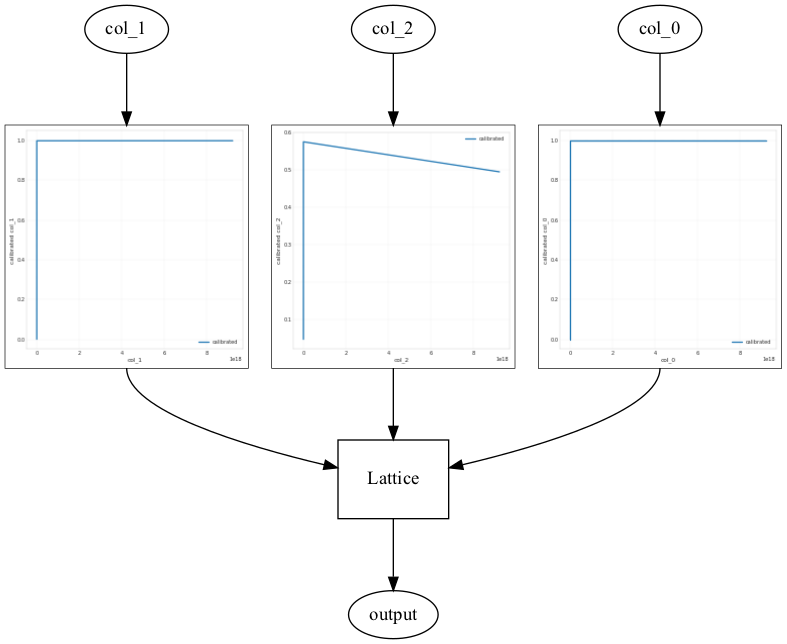

In [51]:
def save_and_visualize_lattice(tfl_estimator):
  saved_model_path = tfl_estimator.export_saved_model(
      "/tmp/TensorFlow_Lattice_101/",
      tf.estimator.export.build_parsing_serving_input_receiver_fn(
          feature_spec=tf.feature_column.make_parse_example_spec(
              feature_columns)))
  model_graph = tfl.estimators.get_model_graph(saved_model_path)
  figsize(8, 8)
  tfl.visualization.draw_model_graph(model_graph)
  return model_graph

_ = save_and_visualize_lattice(tfl_estimator)

In [21]:
def query_to_lattice_input(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    x = [sys.maxsize] * n_column
    for i in range(n_column):
        column_interval[i] = set([0, sys.maxsize])  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        col_idxs = query[1]
        vals = query[3]
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]
        else:
            column_interval[k] = sorted(list(v))
    return column_interval

## Lattice

In [18]:
# 对比，对query做unique 和 不做unique的误差

In [19]:
# 对比传入table unique value 和 只传入 unique_intervals的模型优化效果

In [75]:
# table unique value
data = table.data.to_numpy()
unique_vals = []
for i in range(data.shape[1]):
    unique_vals.append(np.unique(data[:, i]))

In [76]:
unique_vals

[array([5.8, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1,
        7.2, 7.3, 7.4, 7.5, 7.6, 7.9, 8.1, 8.3, 8.5, 8.6, 9.8]),
 array([0.12 , 0.14 , 0.16 , 0.17 , 0.18 , 0.19 , 0.2  , 0.21 , 0.22 ,
        0.23 , 0.24 , 0.25 , 0.26 , 0.265, 0.27 , 0.28 , 0.3  , 0.31 ,
        0.32 , 0.33 , 0.34 , 0.35 , 0.36 , 0.38 , 0.39 , 0.42 , 0.43 ,
        0.44 , 0.45 , 0.46 , 0.47 , 0.48 , 0.54 , 0.66 , 0.67 ])]

## 画图

In [ ]:
# 把plot 整合到 lattice里，或者单独写几个函数

In [36]:
pred = m.inference(grid)

256/256 [==============================] - 0s 774us/step


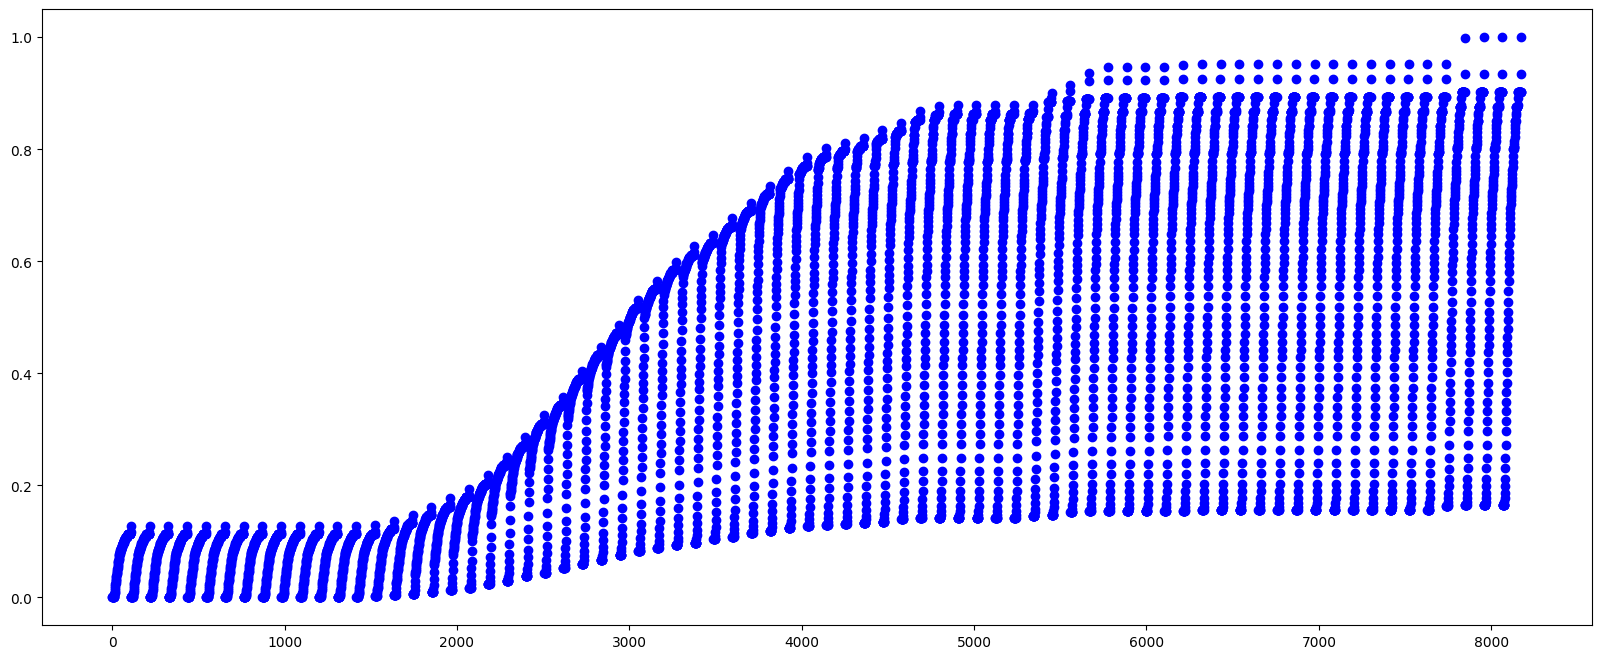

In [37]:
plt.figure(figsize=(20,8))
plt.plot(pred, 'bo')

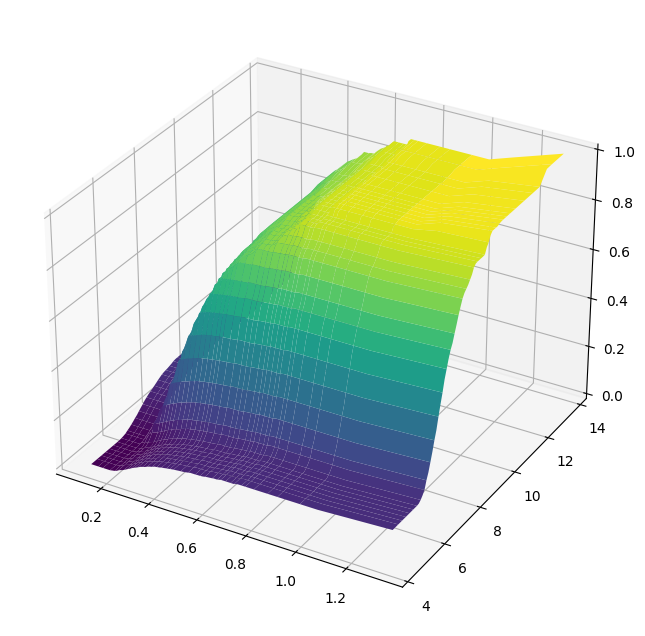

In [38]:
fig1 = plt.figure(figsize=(15,8))
ax1 = plt.axes(projection='3d')

#xx = unique_intervals[1]
#yy = unique_intervals[0]
#X, Y = np.meshgrid(xx, yy)

X = grid[:, 1].reshape(column_interval_number[0], column_interval_number[1])  # 这样也可以
Y = grid[:, 0].reshape(column_interval_number[0], column_interval_number[1])
Z = pred.reshape(column_interval_number[0], column_interval_number[1])

ax1.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

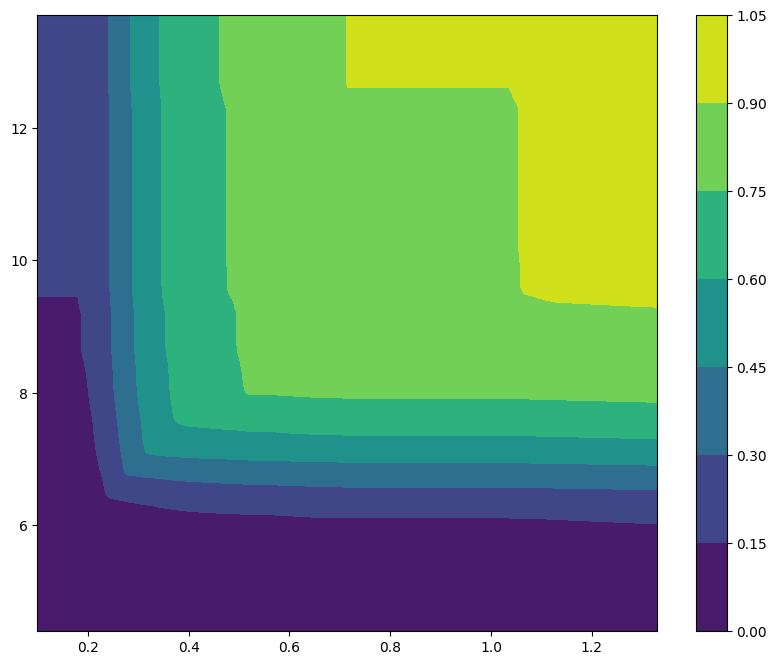

In [40]:
fig2 = plt.figure(figsize=(10,8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap='viridis')

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # 这个是啥

cbar = fig2.colorbar(cs)   # 让colorbar细粒度更高一点
plt.show()

In [30]:
# 画一下原生的图做对比，是否需要更光滑
# 变得光滑：
# 1. 数据预处理，缩放，标准化
# 2. 凸函数
# 3. lattice正则器

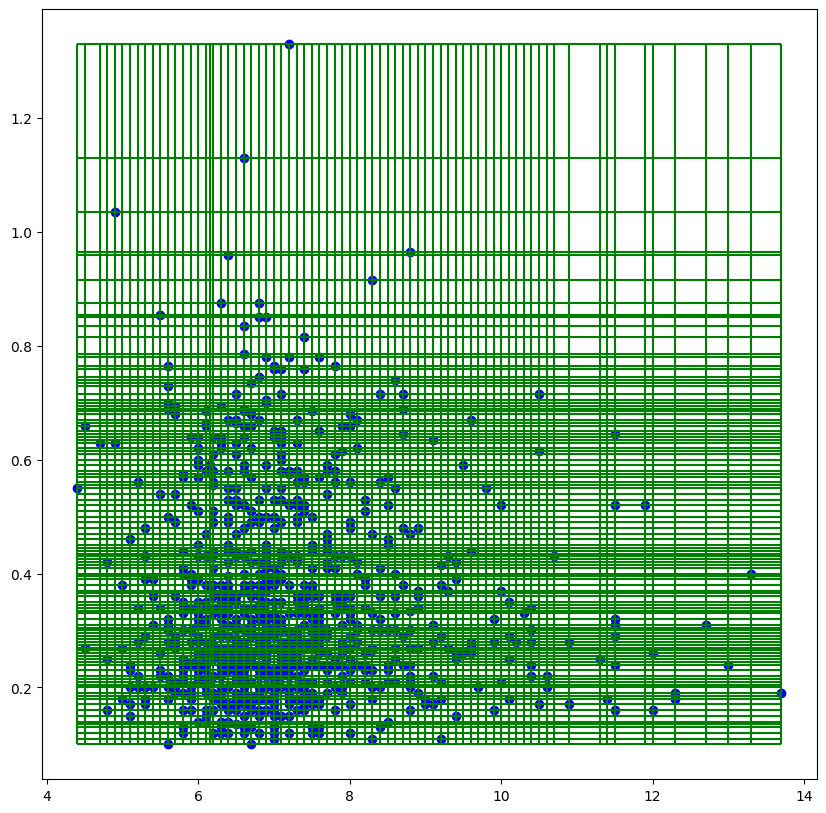

In [41]:
# query 对网格的覆盖率 散点图
fig4 = plt.figure(figsize=(10,10))
xtick = unique_intervals[0]
ytick = unique_intervals[1]
plt.scatter(train_X[:, 0], train_X[:, 1], c='b')
plt.vlines(xtick, min(ytick), max(ytick), colors = "green")
plt.hlines(ytick, min(xtick), max(xtick), colors = "green")
plt.show()

## Test tfl.configs.FeatureConfig

In [42]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE=0.01

In [45]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=df_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    shuffle=False,
)

# feature_analysis_input_fn is used for TF Lattice estimators.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=df_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

In [48]:
feature_columns = [
    tf.feature_column.numeric_column("col_0"),
    tf.feature_column.numeric_column("col_1"),
    tf.feature_column.numeric_column("col_2"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="col_0",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)

In [50]:
from IPython.core.pylabtools import figsize

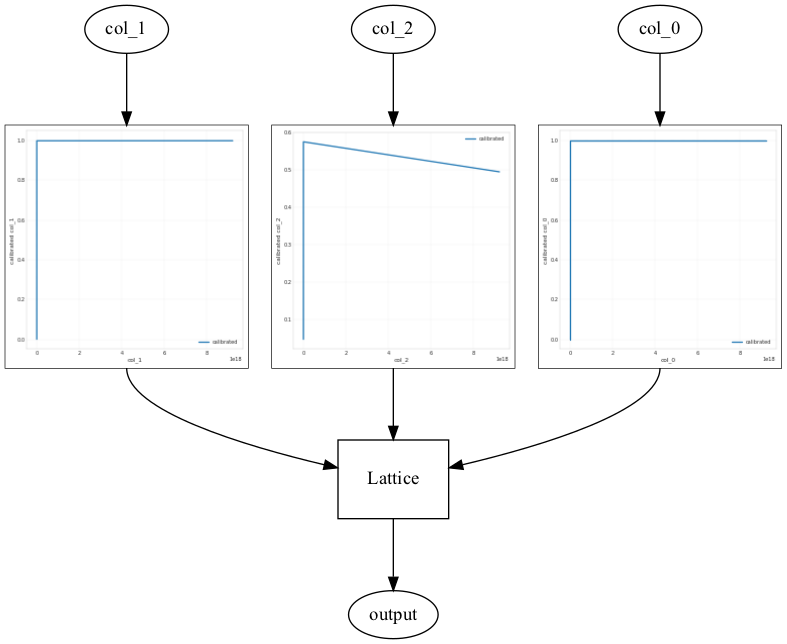

In [51]:
def save_and_visualize_lattice(tfl_estimator):
  saved_model_path = tfl_estimator.export_saved_model(
      "/tmp/TensorFlow_Lattice_101/",
      tf.estimator.export.build_parsing_serving_input_receiver_fn(
          feature_spec=tf.feature_column.make_parse_example_spec(
              feature_columns)))
  model_graph = tfl.estimators.get_model_graph(saved_model_path)
  figsize(8, 8)
  tfl.visualization.draw_model_graph(model_graph)
  return model_graph

_ = save_and_visualize_lattice(tfl_estimator)

In [21]:
def query_to_lattice_input(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    x = [sys.maxsize] * n_column
    for i in range(n_column):
        column_interval[i] = set([0, sys.maxsize])  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        col_idxs = query[1]
        vals = query[3]
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]
        else:
            column_interval[k] = sorted(list(v))
    return column_interval